# Анализ возраста покупателей в прикассовой зоне для сетевого супермаркета
## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
*	Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
*	Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

В вашем распоряжении набор фотографий людей с указанием возраста.
## Порядок выполнения проекта
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению, обучить нейронную сеть.
3. Провести анализ качества нейронной сети.

## Описание данных
Для обучения модели предоставлен набор данных, содержащий:

    file_name - имя файла с фотографией,
    real_age - указанный возраст для человека, изображённого на фотграфии.
Путь к файлу: /datasets/faces/labels.csv
Путь к изображениям: /datasets/faces/final_files/

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Посмотреть на размер выборки

In [3]:
print(labels.shape)
print('----')
print(labels.info())

(7591, 2)
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные загружены. В выборке 7591 элемент. Таблица содержит название файла и установленный возраст для человека на этой фотографии.
### Построить график распределения возраста в выборке

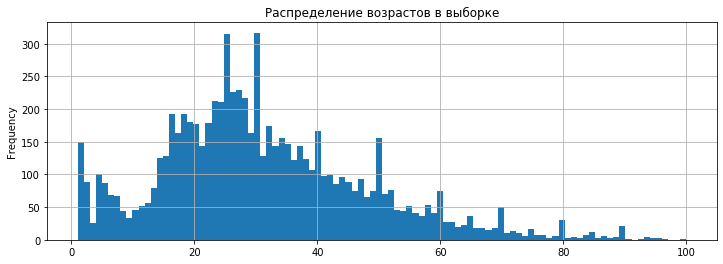

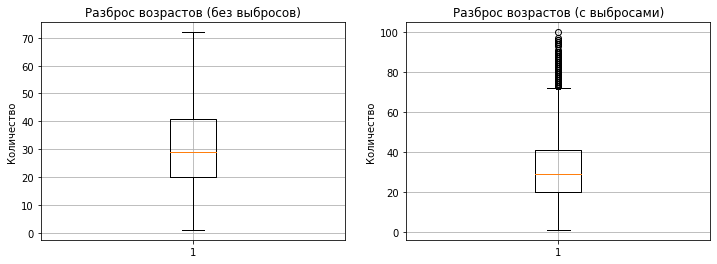

In [5]:
labels.plot(bins=100, kind='hist', grid=True, figsize=(12, 4), \
            title='Распределение возрастов в выборке', legend=False)
plt.show()
fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 4),
    nrows=1, ncols=2)
ax1.boxplot(labels['real_age'], showfliers=False)
ax2.boxplot(labels['real_age'])

ax1.set_title('Разброс возрастов (без выбросов)')
ax1.grid()
ax2.set_title('Разброс возрастов (с выбросами)')
ax2.grid()

ax1.set_ylabel('Количество')
ax2.set_ylabel('Количество')

plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Основная часть данных с людьми в возрасте от 20 до 41 года.

Медиана меньше среднего - набор данных скошен вправо.

Набор данных на 25% состоит из фотографий с людьми от 1 до 20 лет (период в 19 лет) встречаются и на столько же с людьми старше 41 и до 100 лет (период в 59 лет). То есть при достаточно большой разнице в лице в зависимости от возраста у пожилых людей, они представлены меньше всего.

Для этого набора данных возраст выше 72 лет является выбросом.

### Напечатать на экране 10–15 фотографий и посмотреть, как устроен датасет
Данные подгружаются методом flow_from_dataframe.

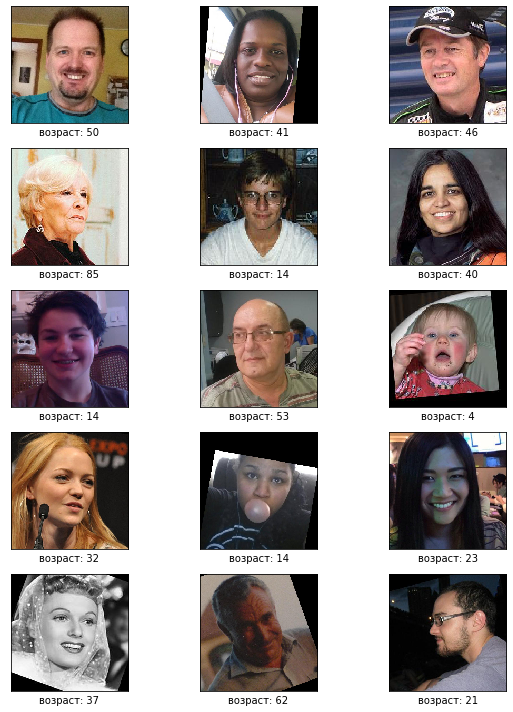

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    ax = fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel('возраст: {}'.format(target[i]))

    plt.tight_layout()

Набор данных содержит фотографии людей, сделанные в разных обстановках, при разном освещении. Лица людей выровнены по вертикальной оси.

### Вывод
Для обучения модель получит набор данных, в котором наибольшее количество изображений с людьми от 20 до 41 года - данную возрастную категорию модель будет опознавать лучше всего. 

Хуже всего модель будет предсказывать возраст пожилых людей.

# 2. Обучение модели

**Загрузка обучающей выборки:**
* Для подготовки обучающей выборки:
    * Загружаем в датафрейм описание данных (связка "файл - возраст").
    * Получаем изображения. Поскольку имеем ограниченный набор данных, увеличим обучающую выборку за счёт "зеркального отображения" фотографий. Далее для работы готовим итератор изображений методом flow_from_dataframe.

**Загрузка валидационной выборки:**
* Порядок работы аналогичен загрузке обучающей выборки с той лишь разницей, что валидационная выборка не изменяется (не применяется аугментация).
* Чтобы обучающая и валидационная выборки не содержали общих элементов, задаём оъектам train_datagen и val_datagen одинаковое значение seed.

**Задание конфигурации модели:**
* Для модели используем ResNet50, которую предобучаем на наборе данных ImageNet. Отключим два слоя "верхушки" и добавим их самостоятельно:
    * Для уменьшения количества параметров модели используем пулинг AveragePooling, который возвращает среднее значение из группы пикселей внутри канала.

    * Полносвязный слой. 
        * Поскольку по фотографии нужно определить возраст человека, перед нами стоит задача регрессии. Имеем набор данных с возрастом от 1 до 100 лет. 
        * Испоьзуем только 1 нейрон, так как в результате необходимо получить только одно число-предсказание. Функция активации определяет выходное значение нейрона в зависимости от результата взвешенной суммы входов и порогового значения. Используем для активации функцию ReLU, так как она не меняет положительные значения, а все отрицательные — приводит к нулю. 

* Для оптимизации скорости обучения используем алгоритм Adam со значением параметра learning rate 0.0005.

* Стоит задача добиться метрики MAE < 8, т.е. наибольшая ошибка в предсказании возраста человека по фотографии - 8 лет (в обе стороны). Поскольку зачастую нейронные сети с функцией потерь MSE обучаются быстрее, укажем, что используем функцию потерь для обучения - MSE, а финальную метрику - MAE.

**Обучение модели:**
* Для обучения модели используем подготовленные ранее обучающую и тестовую выборку.
* Количество эпох подобрано экспериментальным путём. По прошествии 20 эпох модель достаточно хорошо обучилась, чтобы показать на тестовой выборке необходимую точность.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

2020-11-07 11:11:13.957680: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-11-07 11:11:13.959771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-11-07 11:11:15.103927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-07 11:11:15.781656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-11-07 11:11:15.781719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-07 11:11:15.781755: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-07 11:11:15.783783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-11-07 11:11:15.784184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-11-07 11:11:15.786780: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-11-07 11:11:15.788047: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-11-07 11:11:15.788105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-11-07 11:11:15.791653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-11-07 11:11:15.791982: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-11-07 11:11:15.799292: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-11-07 11:11:15.800031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ed2c70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-07 11:11:15.800052: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-07 11:11:15.929498: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5f58c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-11-07 11:11:15.929552: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-11-07 11:11:15.931496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-11-07 11:11:15.931547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-07 11:11:15.931560: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-07 11:11:15.931583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-11-07 11:11:15.931598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-11-07 11:11:15.931611: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-11-07 11:11:15.931623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-11-07 11:11:15.931632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-11-07 11:11:15.935325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-11-07 11:11:15.935382: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-07 11:11:16.282319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-11-07 11:11:16.282370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-11-07 11:11:16.282380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-11-07 11:11:16.286362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-11-07 11:11:29.988862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-07 11:11:30.332479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 55s - loss: 229.4882 - mae: 11.4738 - val_loss: 516.6831 - val_mae: 19.6022
Epoch 2/20
356/356 - 44s - loss: 147.3348 - mae: 9.2927 - val_loss: 281.4272 - val_mae: 12.7337
Epoch 3/20
356/356 - 44s - loss: 121.3029 - mae: 8.4423 - val_loss: 137.6805 - val_mae: 9.5377
Epoch 4/20
356/356 - 44s - loss: 99.8736 - mae: 7.6231 - val_loss: 178.1757 - val_mae: 9.9074
Epoch 5/20
356/356 - 44s - loss: 88.5269 - mae: 7.2422 - val_loss: 122.9682 - val_mae: 8.3542
Epoch 6/20
356/356 - 44s - loss: 70.8250 - mae: 6.5287 - val_loss: 116.1817 - val_mae: 8.1655
Epoch 7/20
356/356 - 44s - loss: 66.1398 - mae: 6.2038 - val_loss: 114.9480 - val_mae: 8.0390
Epoch 8/20
356/356 - 44s - loss: 55.0221 - mae: 5.6936 - val_loss: 133.1765 - val_mae: 8.6656
Epoch 9/20
356/356 - 44s - loss: 45.9186 - mae: 5.2041 - val_loss: 126.7838 - val_mae: 8.5235
Epoch 10/20
356/356 - 44s - loss: 42.0622 - mae: 4.9860 - val_loss: 115.3828 - val_mae: 8.4803
Epoch 11/20
356/356 - 44s - loss: 34.9695 - mae: 4.5598 - val_loss: 95.4302 - val_mae: 7.5342
Epoch 12/20
356/356 - 44s - loss: 28.3726 - mae: 4.1232 - val_loss: 98.8341 - val_mae: 7.4841
Epoch 13/20
356/356 - 44s - loss: 25.1600 - mae: 3.8379 - val_loss: 100.6415 - val_mae: 7.4470
Epoch 14/20
356/356 - 44s - loss: 25.9499 - mae: 3.9696 - val_loss: 94.3947 - val_mae: 7.2247
Epoch 15/20
356/356 - 45s - loss: 22.8116 - mae: 3.6776 - val_loss: 84.9120 - val_mae: 6.9403
Epoch 16/20
356/356 - 44s - loss: 21.7887 - mae: 3.6171 - val_loss: 105.2650 - val_mae: 7.9192
Epoch 17/20
356/356 - 44s - loss: 18.7290 - mae: 3.3582 - val_loss: 79.1231 - val_mae: 6.8266
Epoch 18/20
356/356 - 44s - loss: 18.5301 - mae: 3.2884 - val_loss: 107.2845 - val_mae: 7.6834
Epoch 19/20
356/356 - 44s - loss: 18.9114 - mae: 3.3481 - val_loss: 116.0472 - val_mae: 7.9079
Epoch 20/20
356/356 - 45s - loss: 18.4129 - mae: 3.3069 - val_loss: 84.5420 - val_mae: 6.8846
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 84.5420 - mae: 6.8846
Test MAE: 6.8846

```

# 3. Анализ обученной модели

Обучение на каждой эпохе занимает от 44 до 55 секунд. В совокупности код выполнялся около 20 минут.

Удалось достигнуть значения метрики MAE в 6.88.

Метрика MAE показывает усреднённое положительное значение ошибки предсказания. MAE может быть одинаковым, как для модели, которая все возрастные группы предсказывает одинаково, так и для модели, которая почти идеально предсказывает значения в одной из групп, но заметно хуже справляется с предсказаниями в других группах данных.

В разделе "Исследовательский анализ данных" мы установили, что наибольшее количество данных у нас с людьми в возрасте от 20 до 41 года. Это значит, что, возможно, лучше всего модель предсказывает значения в диапазоне от 20 до 41 и значительно хуже в других диапазонах.

Это может быть критично для задачи *контроля добросовестности кассиров при продаже алкоголя*:
    * так как модель может завысить возраст подростка на несколько лет, продажа алкоголя несовершеннолетнему может остаться незамеченной автоматической системой,
    * так как модель может занизить возраст совершеннолетнего, продажа ему алкоголя может быть приравнена к незаконной.
К счастью, согласно закону, продажа алкоголя допустима только при предъявлении паспорта или приравненного к нему документа. Соответственно, сетевому супермаркету "Хлеб-Соль" следует озаботиться также дополнительной автоматической проверкой на соблюдение этого требования.

Касательно задачи *анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы*: ошибки в предсказанях могут быть не так критичны, поскольку тут предполагается разделение людей на возрастные группы, к примеру: дети, подростки, взрослые, пожилые, долгожители. В соседних группах (куда может случайно направить неверное предсказание) часто могут быть схожие потребительские интересы, например, сладкое для детей и подростков, овощи и фрукты для взрослых и пожилых.

# Общий вывод
Была проведена работа по загрузке и подготовке к работе графических данных. Для предсказания возраста покупателей на кассе была подготовлена и обучена модель ResNet. При обучении в течение 20 эпох модель показывает MAE 6.88, что ниже порогового значения 8. 

Возможно, из-за особенностей обучающих данных лучше всего модель предсказывает значения в диапазоне от 20 до 41 и значительно хуже в других диапазонах. Для оценки качества работы этой модели следует использовать и другие показатели.